<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/LDA_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Topic Modeling Implementation on Tourism Related Articles

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle

## Dataset

Below is our dataset:

In [ ]:
df = pd.read_pickle("drive/My Drive/Topic_Modeling/topic_df.pkl")

In [ ]:
df

Title  ...                                           Abstract
0      TWO-DIRECTIONAL CONVERGENCE OF PLATFORM AND PI...  ...  PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1      EMPLOYEE WELLNESS ON THE FRONTLINE: AN INTERAC...  ...  PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2      DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS OF CON...  ...  PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3      MORE THAN A FEELING? TOWARD A THEORY OF CUSTOM...  ...  PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4      ACCOUNTABLE ALGORITHMS? THE ETHICAL IMPLICATIO...  ...  PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...
...                                                  ...  ...                                                ...
11923  MEASURING SEASONAL DEMAND FOR SPANISH AIRPORTS...  ...  USING GINI COEFFICIENTS, THIS PAPER INVESTIGAT...
11924  NEW EMPIRICAL EVIDENCE ON AIRPORT CAPACITY UTI...  ...  AN IMPORTANT QUESTION IN FORECASTING AIR TRAFF...
11925  POTENTIAL FOR ABU DHABI, DOHA AND DUBAI AIRPOR...  ...  THE AIR TRANSPORT MARKET IN THE MIDDLE EAST IS...
11926  SEEDING GROWTH AT AIRPORTS AND AIRPORT CITIES:...  ...  AIRPORTS ARE EVOLVING FROM SIMPLE INFRASTRUCTU...
11927  THE OBJECTIVES AND OUTCOMES OF AIRPORT PRIVATI...  ...  AIRPORT PRIVATISATION IS A CONTROVERSIAL YET G...

[11928 rows x 4 columns]

The dataset includes **11928** articles from **19 journals**, including title, journal name, publication year and abstract information.

In [ ]:
df.groupby('Journal')['Abstract'].count().sort_values()

Journal
JOURNAL OF VACATION MARKETING                                    254
SCANDINAVIAN JOURNAL OF HOSPITALITY AND TOURISM                  257
RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT                 300
TOURISM RECREATION RESEARCH                                      308
JOURNAL OF SERVICE MANAGEMENT                                    316
JOURNAL OF HOSPITALITY AND TOURISM MANAGEMENT                    318
CORNELL HOSPITALITY QUARTERLY                                    331
JOURNAL OF HOSPITALITY AND TOURISM RESEARCH                      352
JOURNAL OF HOSPITALITY MARKETING & MANAGEMENT                    407
INTERNATIONAL JOURNAL OF TOURISM RESEARCH                        552
TOURISM MANAGEMENT PERSPECTIVES                                  601
JOURNAL OF TRAVEL & TOURISM MARKETING                            624
JOURNAL OF TRAVEL RESEARCH                                       686
ANNALS OF TOURISM RESEARCH                                       710
JOURNAL OF SUSTAINABLE TOU

The number of articles per journal is as above: 

In [ ]:
order = df.Journal.value_counts(ascending=True).index

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


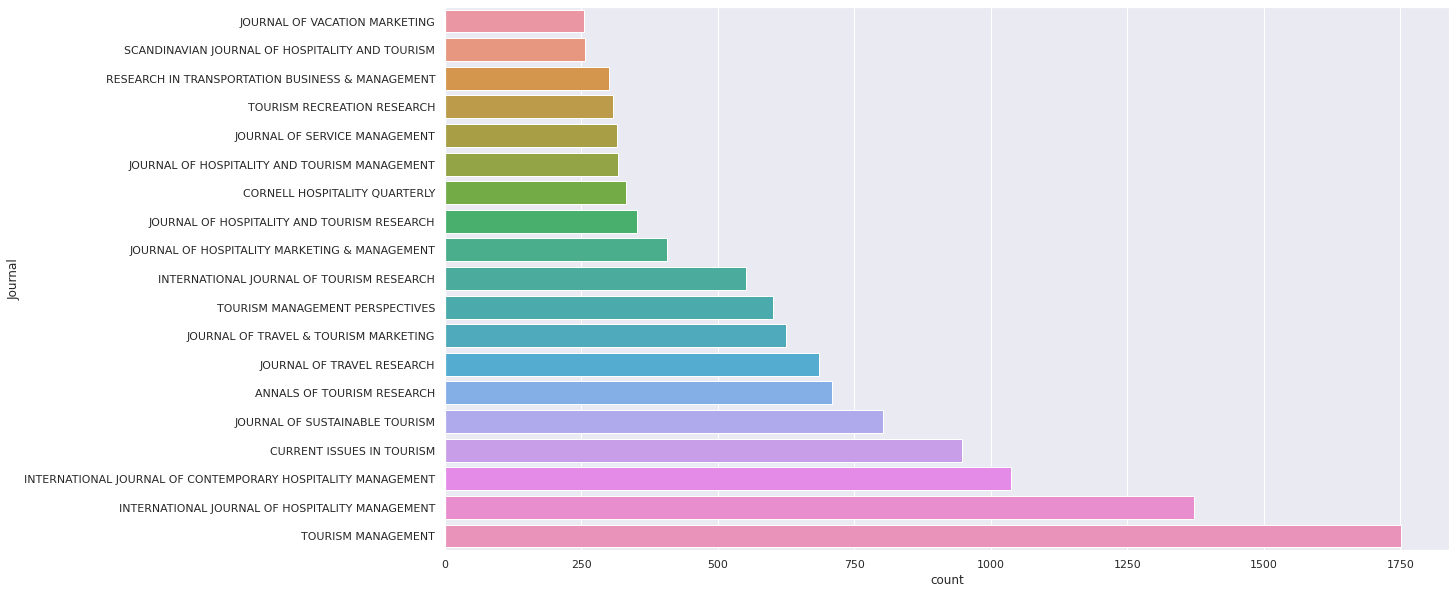

In [ ]:
plt.figure(figsize=(18,10))
sns.countplot(y='Journal', data=df, orient='h', order=order);

You can find graph version the same info above:

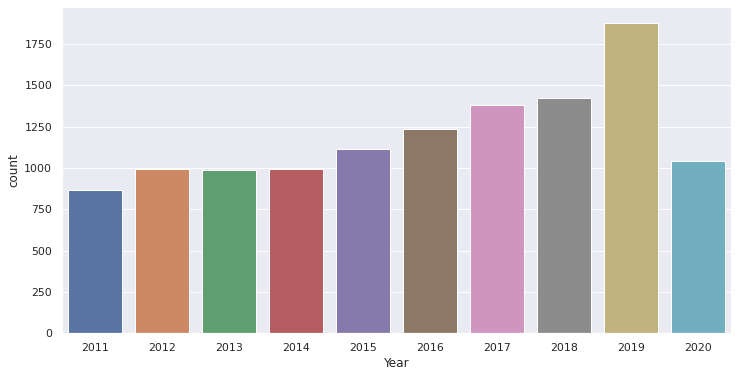

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Year', data=df, orient='v');

The number of yearly publications is above:

In [ ]:
def color_zeros(val):
  background_color = 'yellow' if val == 0 else 'white'
  return 'background-color: %s' % background_color

In [ ]:
df_o = pd.crosstab(df.Journal, df.Year, dropna=False).style.applymap(color_zeros)
df_o

The number of articles per journal per year is above:

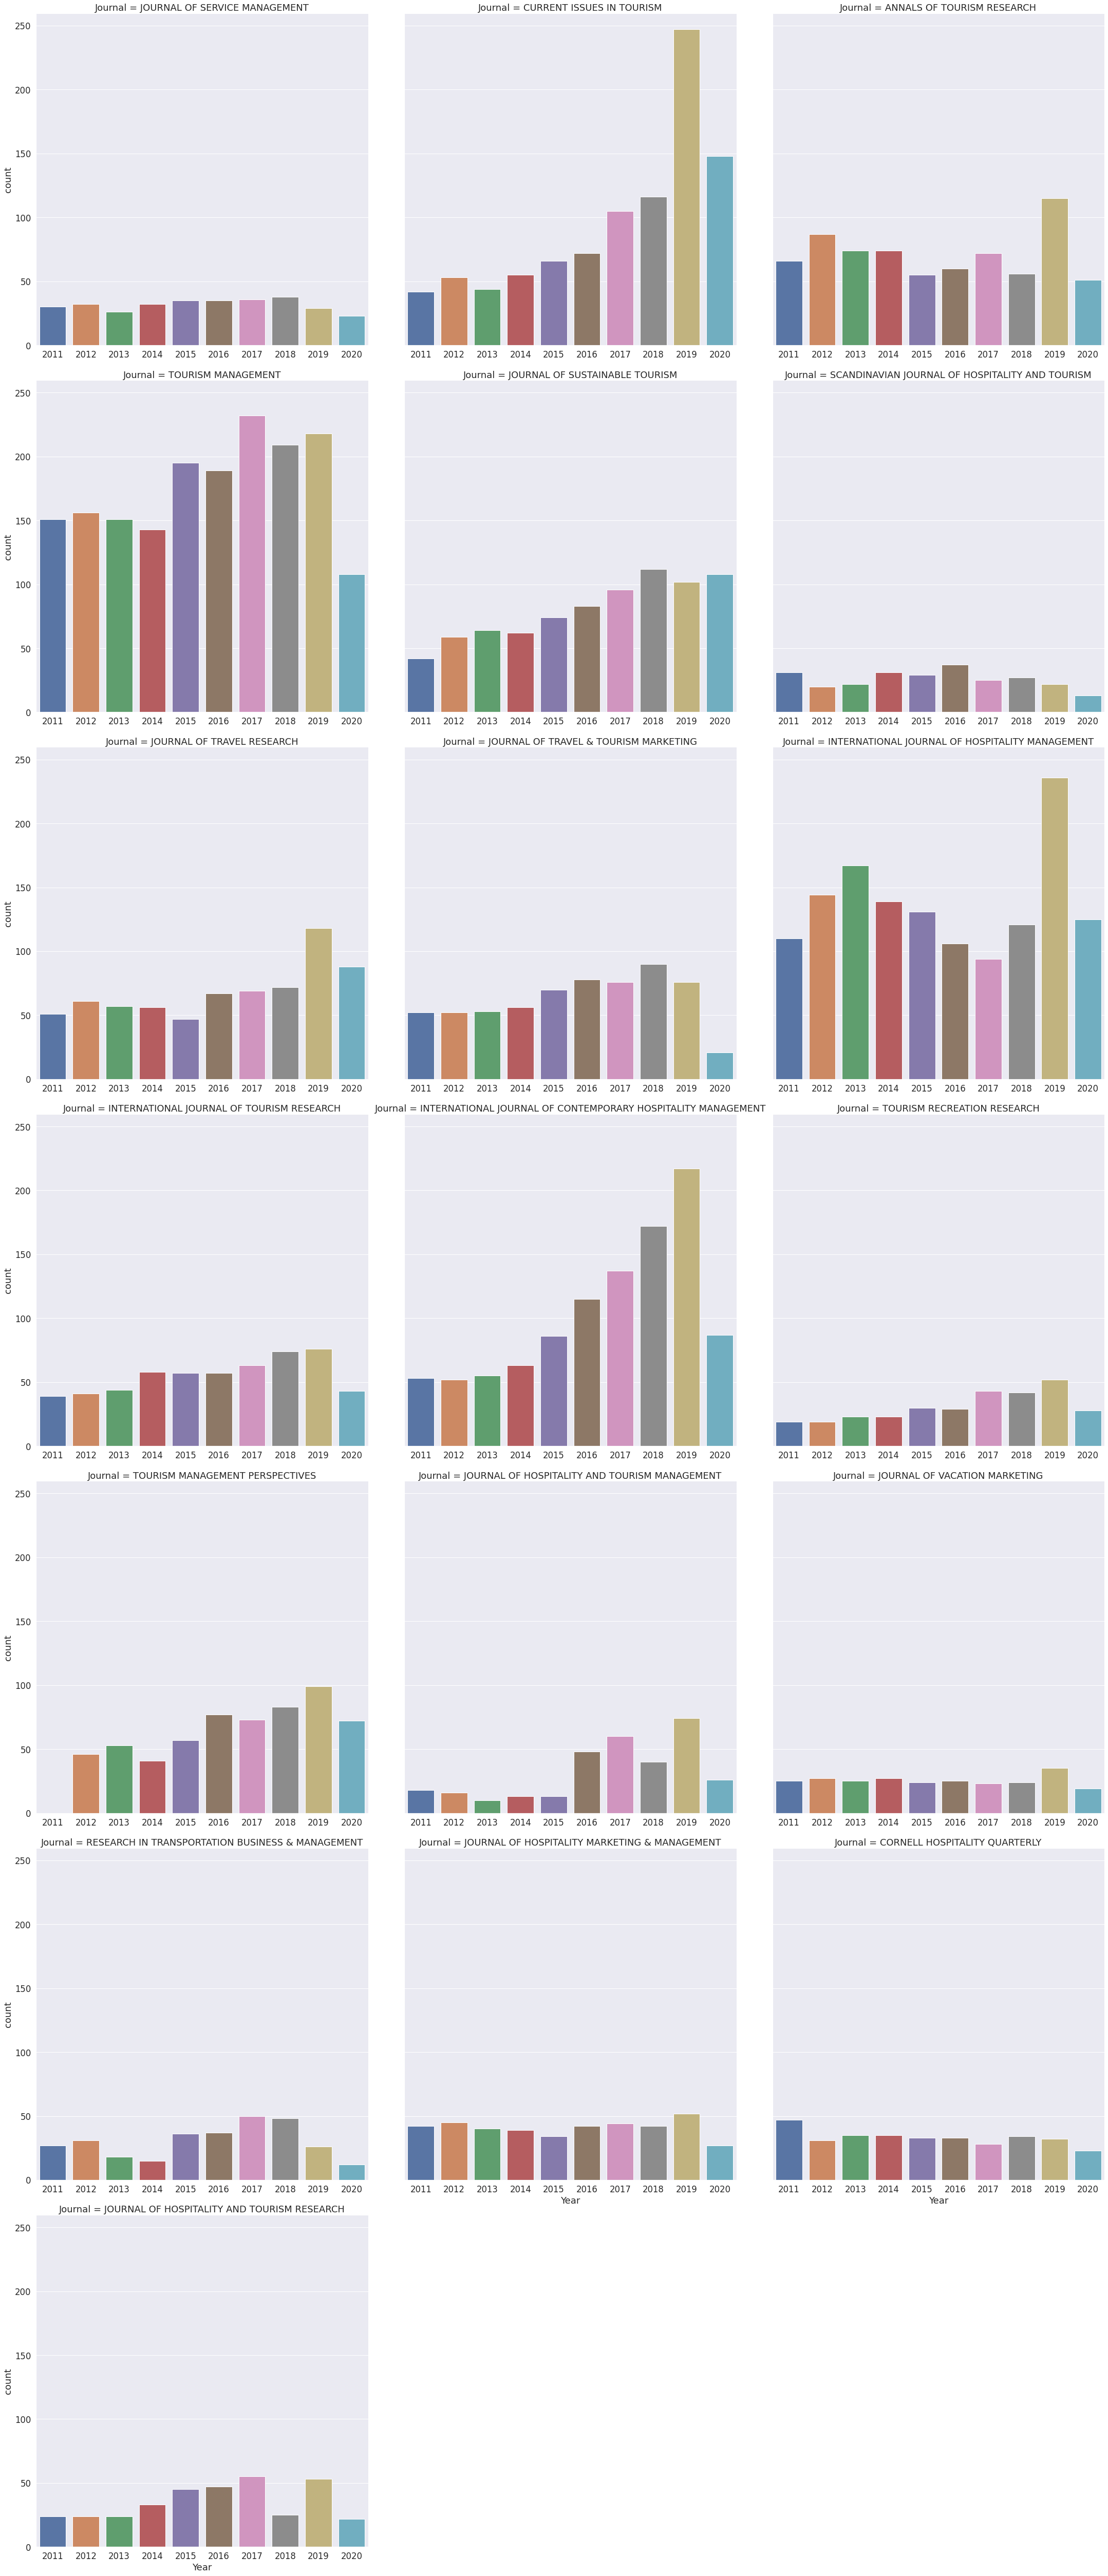

In [ ]:
sns.set(font_scale=1.5)
sns.catplot(data=df, x='Year', col="Journal", col_wrap=3, sharex=False, height=10, kind='count');


Subgraphs for the number of articles per year per journal are above:

## Analysis

In [ ]:
papers = list(df.Abstract.values)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
!pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

### Tokenize Sentences and Clean

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = papers
data_words = list(sent_to_words(data))

### Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token.text)>3])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready = process_words(data_words)  # processed Text Data!

Above we preprocess the corpus that includes: 
- removing stop words,
- doing lemmatization,
- implementing ngrams,
- selection of tokens based on speech of tags (*keep the words that are either noun, adjective, verb or adverb*)

### Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 17550


After preprocessing step we form a dictionary that the model requires.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq


In [ ]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

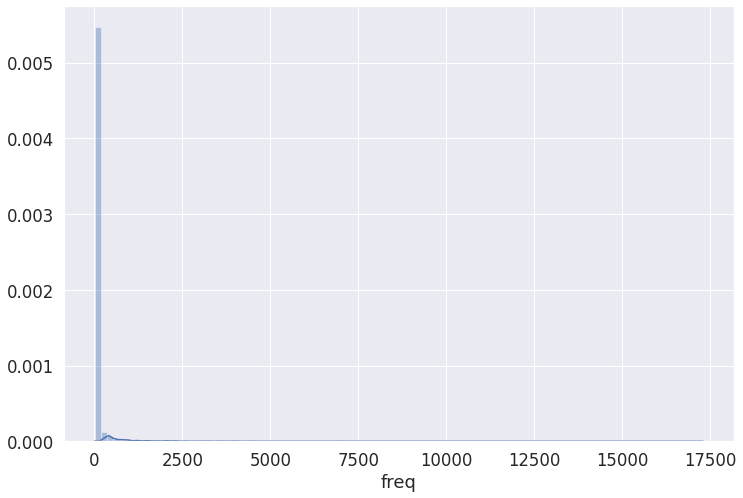

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.distplot(dict_df['freq'], bins=100);

Above is the graph for word frequencies of our dictionary, just to have general idea about the words and their frequencies. Most of the words have frequency values less than 1000. 

Below you can find the list of high frequency words in descending order. We will add those words that appear 2000 times or  more to stop list and restart the preprocess step to get better topic clusters. As expected, sector specific and general writing words have high frequencies.  

In [ ]:
dict_df[dict_df.freq>2000].sort_values('freq', ascending=False).head(60)

freq
tourism       17300
study         16528
tourist        8152
hotel          7645
research       7636
use            7206
result         6996
service        6960
customer       6049
destination    6044
finding        5812
experience     5602
paper          5478
model          5439
effect         5365
relationship   4841
base           4684
examine        4382
implication    4372
provide        4148
influence      4098
also           3982
industry       3968
impact         3928
value          3910
travel         3899
analysis       3657
social         3585
satisfaction   3549
employee       3536
show           3466
development    3314
hospitality    3260
factor         3235
datum          3212
perceive       3129
performance    3076
identify       3074
purpose        3060
management     3048
develop        2943
role           2933
level          2901
different      2862
consumer       2839
find           2721
approach       2712
high           2657
suggest        2627
behavior       2601
investigate    2584
positive       2543
quality        2461
brand          2440
literature     2422
market         2401
restaurant     2344
increase       2343
explore        2337
significant    2336

In [ ]:
extension = dict_df[dict_df.freq>2000].index.tolist()

In [ ]:
stop_words.extend(extension)

In [ ]:
data_ready = process_words(data_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 17647


 After removing the high frequency words there remains **17460** words in our dictionary.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#ids = [id2word.token2id[extension[i]] for i in range(len(extension))]

In [ ]:
#id2word.filter_tokens(bad_ids=ids)

Next, we removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 50% of all the documents. We are interested in finding different themes and topics and not recurring themes.

In [ ]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.

id2word.filter_extremes(no_below=20, no_above=0.5)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 2914


After final step there are **2886** words in the dictionary.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Build the Topic Model

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-06-28 10:01:14--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  11.7MB/s    in 1.3s    

2020-06-28 10:01:15 (11.7 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet( mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Below you can find the 10 topics formed by the model. For each topic there are 10 terms and their relative weights next to it in descending order.

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('article', 0.02763103732162459),
   ('future', 0.02689352360043908),
   ('event', 0.025384193194291988),
   ('resident', 0.024440861690450056),
   ('discuss', 0.01993002195389682),
   ('place', 0.019655598243688253),
   ('concept', 0.01953553787047201),
   ('present', 0.018746569703622394),
   ('perspective', 0.018420691547749727),
   ('researcher', 0.015247667398463227)]),
 (1,
  [('image', 0.03249277556075409),
   ('affect', 0.032183156735929544),
   ('dimension', 0.028794550708683087),
   ('loyalty', 0.027487271226090546),
   ('moderate', 0.021346497867070317),
   ('attitude', 0.01931677445988716),
   ('negative', 0.018989954589239025),
   ('theoretical', 0.018284711710471996),
   ('mediate', 0.015979771570111462),
   ('significantly', 0.015962570524287876)]),
 (2,
  [('firm', 0.03549101561104562),
   ('sector', 0.02257707283963848),
   ('company', 0.018451041331761512),
   ('cost', 0.015450291144214624),
   ('financial', 0.014074947308255635),
   ('improve', 0.013128282070

In [ ]:
pickle.dump(ldamallet, open("drive/My Drive/Topic_Modeling/lda_mallet_10.pkl", "wb"))

In [ ]:
ldamallet = pickle.load(open("drive/My Drive/Topic_Modeling/lda_mallet_10.pkl", "rb"))

In [ ]:
tm_results = ldamallet[corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=10)] for n in range(0, ldamallet.num_topics)]


Below is the Topic-Term matrix shows 10 terms that forms each topic.   

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 11)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df

Topic 1        Topic 2  ...         Topic 9        Topic 10
Term1       article          image  ...   environmental       knowledge
Term2        future         affect  ...     sustainable       practical
Term3         event      dimension  ...          policy     originality
Term4      resident        loyalty  ...          system  organizational
Term5       discuss       moderate  ...          change      innovation
Term6         place       attitude  ...     stakeholder         context
Term7       concept       negative  ...        resource      limitation
Term8       present    theoretical  ...  sustainability      contribute
Term9   perspective        mediate  ...         network    organization
Term10   researcher  significantly  ...         benefit             aim

[10 rows x 10 columns]

In [ ]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


### WordClouds

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]

Below is the word clouds, one for each topic. The font sizes of words show their relative weights in the topic.

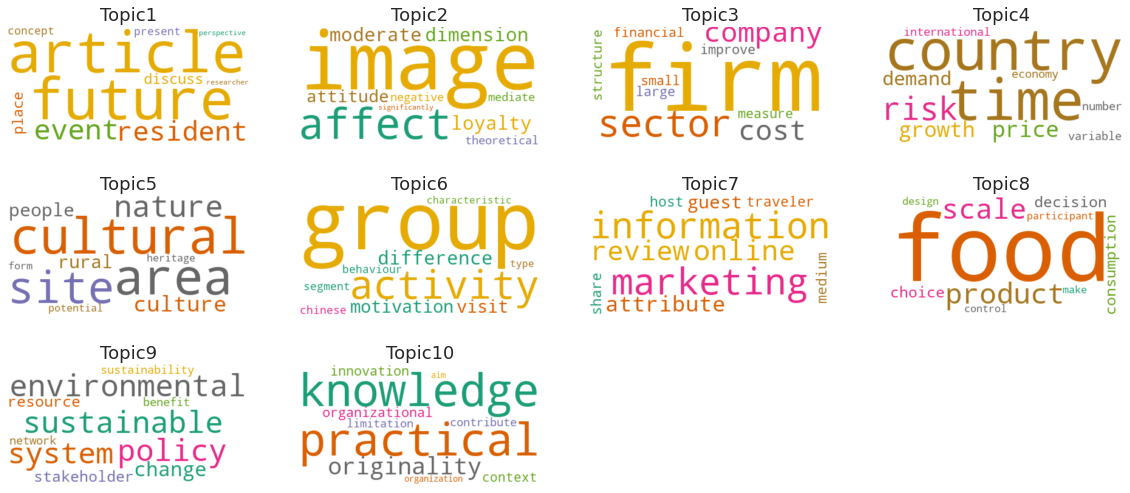

In [ ]:
# Create subplots for each comedian
i=0
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
new_lda = convertldaGenToldaMallet(ldamallet)

Below is an interactive graph shows the topics and relative terms. You can hover over bubbles and get the most relevant 30 words on the right.


In [ ]:
vis_data = gensimvis.prepare(new_lda, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
corpus_topic_df = pd.DataFrame()

corpus_topic_df['Document'] = range(0, len(corpus))

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]

corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]

corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df['Title'] = df.Title

Below table shows the dominant topic, its weight and the title of each document. 

In [ ]:
corpus_topic_df

Document  ...                                                                                                                                  Title
0      0         ...  TWO-DIRECTIONAL CONVERGENCE OF PLATFORM AND PIPELINE BUSINESS MODELS                                                                 
1      1         ...  EMPLOYEE WELLNESS ON THE FRONTLINE: AN INTERACTIONAL PSYCHOLOGY PERSPECTIVE                                                          
2      2         ...  DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS OF CONSUMERS' USE AND SELF-INVESTMENT TRAJECTORIES OVER TIME IN AN ONLINE TV CONTENT PLATFORM
3      3         ...  MORE THAN A FEELING? TOWARD A THEORY OF CUSTOMER DELIGHT                                                                             
4      4         ...  ACCOUNTABLE ALGORITHMS? THE ETHICAL IMPLICATIONS OF DATA-DRIVEN BUSINESS MODELS                                                      
...   ..         ...                                                                              ...                                                      
11923  11923     ...  MEASURING SEASONAL DEMAND FOR SPANISH AIRPORTS: IMPLICATIONS\nFOR COUNTER-SEASONAL STRATEGIES                                        
11924  11924     ...  NEW EMPIRICAL EVIDENCE ON AIRPORT CAPACITY UTILISATION: RELATIONSHIPS BETWEEN HOURLY\nAND ANNUAL AIR TRAFFIC VOLUMES                 
11925  11925     ...  POTENTIAL FOR ABU DHABI, DOHA AND DUBAI AIRPORTS TO REACH THEIR TRAFFIC OBJECTIVES                                                   
11926  11926     ...  SEEDING GROWTH AT AIRPORTS AND AIRPORT CITIES: INSIGHTS FROM THE TWO-SIDED\nMARKET LITERATURE                                        
11927  11927     ...  THE OBJECTIVES AND OUTCOMES OF AIRPORT PRIVATISATION                                                                                 

[11928 rows x 5 columns]

### Dominant Topics Distribution Across Corpus

The first thing we can do is look at the overall distribution of each topic across the corpus of research papers.

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

# topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()

topic_stats_df['Total_Docs_Perc'] = topic_stats_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]

topic_stats_df

Dominant Topic  ...                                                                                                         Topic Desc
0               1  ...                        article, future, event, resident, discuss, place, concept, present, perspective, researcher
1               2  ...               image, affect, dimension, loyalty, moderate, attitude, negative, theoretical, mediate, significantly
2               3  ...                                  firm, sector, company, cost, financial, improve, small, large, measure, structure
3               4  ...                               country, time, risk, price, growth, demand, international, number, variable, economy
4               5  ...                                    cultural, area, site, nature, culture, people, rural, potential, form, heritage
5               6  ...                  group, activity, difference, motivation, visit, behaviour, segment, chinese, characteristic, type
6               7  ...                            information, marketing, online, review, attribute, guest, traveler, medium, host, share
7               8  ...                            food, product, scale, decision, choice, consumption, participant, design, make, control
8               9  ...        environmental, sustainable, policy, system, change, stakeholder, resource, sustainability, network, benefit
9              10  ...  knowledge, practical, originality, organizational, innovation, context, limitation, contribute, organization, aim

[10 rows x 4 columns]

In [ ]:
topic_counts = topic_stats_df[["Dominant Topic", 	"Doc_Count", "Total_Docs_Perc"]]
topic_counts.columns  = ["Dominant Topic", 	"Document Count", "Total Document Percentage"]
topic_counts

Dominant Topic  Document Count  Total Document Percentage
0               1            1151                       9.65
1               2            1588                      13.31
2               3             986                       8.27
3               4            1378                      11.55
4               5            1246                      10.45
5               6            1090                       9.14
6               7            1229                      10.30
7               8             928                       7.78
8               9            1343                      11.26
9              10             989                       8.29

### Relevant Research Papers per Topic Based on Dominance



In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

Document  ...                                                                                                                                                                     Title
0      8639  ...                                                                 THE EVOLUTION OF BUSINESS ETHICS RESEARCH IN THE REALM OF TOURISM AND HOSPITALITY A BIBLIOMETRIC ANALYSIS
1      9852  ...  SYNTHESIZING THE EFFECTS OF EXPERIENTIAL QUALITY, EXCITEMENT, EQUITY, EXPERIENTIAL SATISFACTION ON EXPERIENTIAL LOYALTY FOR THE GOLF INDUSTRY: THE CASE OF HAINAN ISLAND
2      8888  ...                                                                                                                      THE MARKET PERFORMANCE OF FRANCHISE STOCK PORTFOLIOS
3      5357  ...                                                                             DETERMINANTS VERSUS COMPOSITE LEADING INDICATORS IN PREDICTING TURNING POINTS IN GROWTH CYCLE
4      4529  ...                                                                         SCALAR POLITICS OF BORDER HERITAGE: AN EXAMINATION OF THE EU'S NORTHERN AND SOUTHERN BORDER AREAS
5      7482  ...                              PROFILING CHINESE WINE TOURISTS BY WINE TOURISM CONSTRAINTS: A COMPARISON OF CHINESE AUSTRALIANS AND LONG-HAUL CHINESE TOURISTS IN AUSTRALIA
6     10646  ...                                                       THE INFLUENCE OF EMBEDDED SOCIAL MEDIA CHANNELS ON TRAVELERS' GRATIFICATIONS, SATISFACTION, AND PURCHASE INTENTIONS
7      6352  ...                                                                 WHEN ORGANIC FOOD CHOICES SHAPE SUBSEQUENT FOOD CHOICES: THE INTERPLAY OF GENDER AND HEALTH CONSCIOUSNESS
8      4313  ...                                           ASSESSING THE SUSTAINABILITY OF AGRITOURISM IN THE US: A COMPARISON BETWEEN AGRITOURISM AND OTHER FARM ENTREPRENEURIAL VENTURES
9     10528  ...                                            PSYCHOLOGICAL DIVERSITY CLIMATE, ORGANIZATIONAL EMBEDDEDNESS, AND TURNOVER INTENTIONS: A CONSERVATION OF RESOURCES PERSPECTIVE

[10 rows x 5 columns]

In [ ]:
tm_results = ldamallet[corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Below is the table that shows topic weights for each  document.  

In [ ]:
df_e = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_e.columns = ['Topic ' + str(i) for i in range(1,11)]
df_e

Topic 1   Topic 2   Topic 3  ...   Topic 8   Topic 9  Topic 10
0      0.081226  0.059004  0.153257  ...  0.070498  0.202299  0.059770
1      0.200747  0.061625  0.070028  ...  0.136321  0.080299  0.242764
2      0.040258  0.157005  0.123994  ...  0.054750  0.041063  0.119968
3      0.154882  0.074074  0.131313  ...  0.082828  0.055219  0.127273
4      0.139376  0.050682  0.093567  ...  0.059454  0.111111  0.239766
...         ...       ...       ...  ...       ...       ...       ...
11923  0.062169  0.064815  0.190476  ...  0.084656  0.067460  0.088624
11924  0.102339  0.054581  0.257310  ...  0.050682  0.064327  0.050682
11925  0.073355  0.061489  0.241640  ...  0.065804  0.099245  0.063646
11926  0.089606  0.053763  0.237754  ...  0.088411  0.093190  0.086022
11927  0.118437  0.067155  0.275946  ...  0.078144  0.103785  0.067155

[11928 rows x 10 columns]

In [ ]:
df_e['Year'] = df.Year; df_e['Journal'] = df.Journal

Below table shows the topic distribuiton on a yearly basis. It is calculated by getting the mean of topic weights of all the documents published in a given year. Since the values are so close to each other it is difficult to get trends from this table.

In [ ]:
df_e.groupby('Year').mean()

Topic 1   Topic 2   Topic 3  ...   Topic 8   Topic 9  Topic 10
Year                                ...                              
2011  0.100424  0.094019  0.105381  ...  0.096595  0.103678  0.096482
2012  0.100645  0.095600  0.104655  ...  0.099223  0.104833  0.095970
2013  0.102657  0.100869  0.099900  ...  0.099513  0.102279  0.096710
2014  0.103406  0.100684  0.098583  ...  0.096708  0.103095  0.097550
2015  0.100635  0.100135  0.102824  ...  0.098468  0.099976  0.098256
2016  0.101432  0.103027  0.096650  ...  0.097390  0.101414  0.101529
2017  0.102974  0.101530  0.097426  ...  0.097891  0.101985  0.098965
2018  0.103763  0.105096  0.096781  ...  0.097593  0.102131  0.100091
2019  0.100670  0.109822  0.094530  ...  0.097804  0.097899  0.101700
2020  0.100595  0.109224  0.094611  ...  0.097538  0.100280  0.100315

[10 rows x 10 columns]

In [ ]:
df_jy = df_e.groupby(['Journal', 'Year']).mean()

Below table shows the topic distribuiton over years per journal. Even with this table the trends are not clear. 

In [ ]:
df_jy

Topic 1   Topic 2  ...   Topic 9  Topic 10
Journal                     Year                      ...                    
ANNALS OF TOURISM RESEARCH  2011  0.122559  0.088336  ...  0.101859  0.086463
                            2012  0.124044  0.088301  ...  0.099146  0.094360
                            2013  0.128796  0.089901  ...  0.101184  0.089534
                            2014  0.118778  0.088575  ...  0.097912  0.092802
                            2015  0.131533  0.090023  ...  0.097792  0.089239
...                                    ...       ...  ...       ...       ...
TOURISM RECREATION RESEARCH 2016  0.112241  0.077528  ...  0.112693  0.095931
                            2017  0.133146  0.078619  ...  0.123514  0.097996
                            2018  0.121372  0.075921  ...  0.126591  0.080106
                            2019  0.132896  0.082886  ...  0.118901  0.097167
                            2020  0.117716  0.075337  ...  0.125642  0.102783

[189 rows x 10 columns]

In [ ]:
df_e.drop(['Year', 'Journal'], axis=1, inplace=True)

In [ ]:
df_e['Max'] = df_e.idxmax(axis=1)

In [ ]:
df_e['Year']= df.Year; df_e['Journal']=df.Journal

Therefore we decided to find most dominant topic for each document rather than averaging the topic weights and then compute the percentage of documents in a given year where the topic is the most dominant. Below you can see on "Max" column the most dominant topic for each document. 

In [ ]:
df_e

Topic 1  ...                                           Journal
0      0.081226  ...                     JOURNAL OF SERVICE MANAGEMENT
1      0.200747  ...                     JOURNAL OF SERVICE MANAGEMENT
2      0.040258  ...                     JOURNAL OF SERVICE MANAGEMENT
3      0.154882  ...                     JOURNAL OF SERVICE MANAGEMENT
4      0.139376  ...                     JOURNAL OF SERVICE MANAGEMENT
...         ...  ...                                               ...
11923  0.062169  ...  RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT
11924  0.102339  ...  RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT
11925  0.073355  ...  RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT
11926  0.089606  ...  RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT
11927  0.118437  ...  RESEARCH IN TRANSPORTATION BUSINESS & MANAGEMENT

[11928 rows x 13 columns]

Below is the dominant topics and their frequencies across the corpus.

In [ ]:
df_e.Max.value_counts()

Topic 2     1588
Topic 4     1378
Topic 9     1343
Topic 5     1246
Topic 7     1229
Topic 1     1151
Topic 6     1090
Topic 10     989
Topic 3      986
Topic 8      928
Name: Max, dtype: int64

In [ ]:
df_count = df_e.groupby('Year')['Max'].value_counts().unstack()

In [ ]:
df_count['Total'] = df_count.sum(axis=1)


We computed the prevalence of the topics by identifying the topic with the highest weight per document, grouping the results by year, adding up the number of top occurrences of each topic per year and dividing by the total number of documents per year. as seen below the trends are more clear.

In [ ]:
df_count = df_e.groupby('Year')['Max'].value_counts(normalize=True).unstack()
df_count['Total'] = df_count.sum(axis=1)
df_count

Max    Topic 1  Topic 10   Topic 2  ...   Topic 8   Topic 9  Total
Year                                ...                           
2011  0.094361  0.070196  0.105869  ...  0.057537  0.125432    1.0
2012  0.086345  0.069277  0.103414  ...  0.085341  0.119478    1.0
2013  0.100508  0.079188  0.130964  ...  0.091371  0.111675    1.0
2014  0.103518  0.076382  0.137688  ...  0.073367  0.126633    1.0
2015  0.097583  0.081468  0.121755  ...  0.076097  0.099373    1.0
2016  0.100243  0.089733  0.121261  ...  0.078416  0.111560    1.0
2017  0.110065  0.086894  0.130340  ...  0.072411  0.116582    1.0
2018  0.098947  0.087719  0.132632  ...  0.081404  0.107368    1.0
2019  0.091538  0.089409  0.163385  ...  0.077169  0.105375    1.0
2020  0.079502  0.086207  0.158046  ...  0.083333  0.113027    1.0

[10 rows x 11 columns]

Below table shows the average prevelance of topics for each journal in a given year.

In [ ]:
df_count_j = df_e.groupby(['Journal', 'Year'])['Max'].value_counts(normalize=True).unstack()
df_count_j['Total'] = df_count_j.sum(axis=1)
df_j = df_count_j.reset_index()

# delete the columns name
df_j.columns.name=None

df_j.set_index(['Journal', 'Year'])

Topic 1  Topic 10  ...   Topic 9  Total
Journal                     Year                      ...                 
ANNALS OF TOURISM RESEARCH  2011  0.212121       NaN  ...  0.090909    1.0
                            2012  0.149425  0.045977  ...  0.068966    1.0
                            2013  0.202703  0.054054  ...  0.108108    1.0
                            2014  0.175676  0.027027  ...  0.081081    1.0
                            2015  0.254545  0.054545  ...  0.072727    1.0
...                                    ...       ...  ...       ...    ...
TOURISM RECREATION RESEARCH 2016  0.068966  0.068966  ...  0.103448    1.0
                            2017  0.209302  0.069767  ...  0.186047    1.0
                            2018  0.142857       NaN  ...  0.166667    1.0
                            2019  0.250000  0.076923  ...  0.173077    1.0
                            2020  0.107143  0.142857  ...  0.250000    1.0

[189 rows x 11 columns]

In [ ]:
df_j_melted = df_j.melt(id_vars=['Journal', 'Year'], value_vars=['Topic ' + str(i) for i in range(1,11)], var_name='Topic', value_name='Prevelance')

Below you can find subgraphs for topic distribuition over time for each journal.

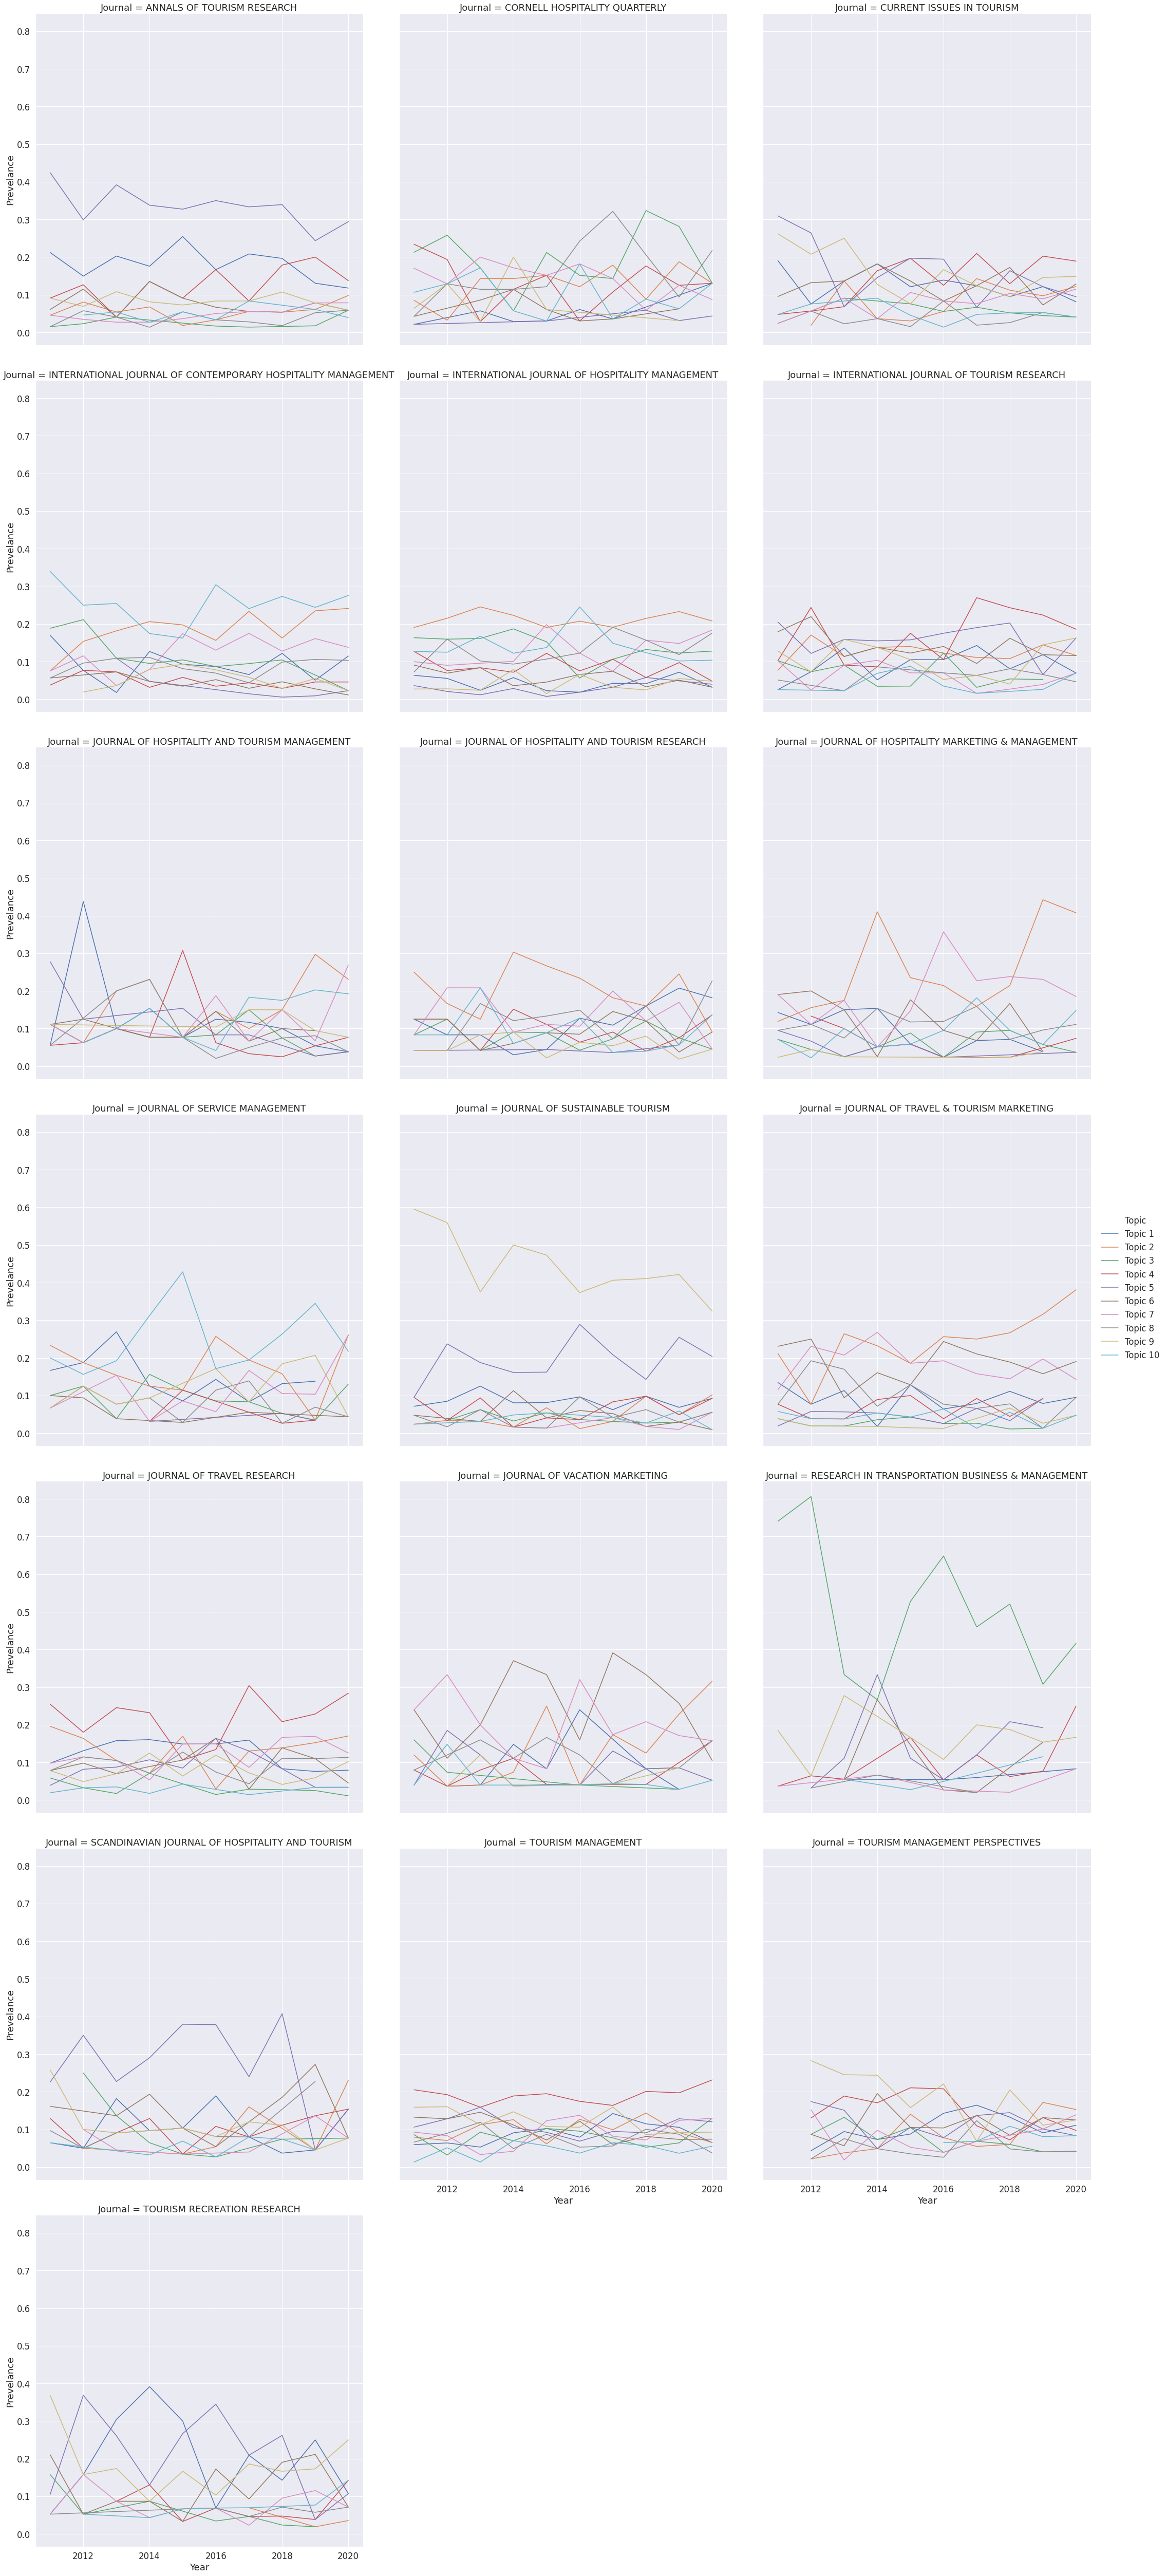

In [ ]:
sns.relplot(x='Year', y="Prevelance", col="Journal", col_wrap=3, hue='Topic',
data=df_j_melted,
kind="line",
height=10,
style="Topic",
# markers=True)
dashes=False,
ci=None)

In [ ]:
df_count_j.drop('Total', axis=1, inplace=True)

In [ ]:
df_count_j

Max                                Topic 1  Topic 10  ...   Topic 8   Topic 9
Journal                     Year                      ...                    
ANNALS OF TOURISM RESEARCH  2011  0.212121       NaN  ...  0.015152  0.090909
                            2012  0.149425  0.045977  ...  0.057471  0.068966
                            2013  0.202703  0.054054  ...  0.040541  0.108108
                            2014  0.175676  0.027027  ...  0.013514  0.081081
                            2015  0.254545  0.054545  ...  0.054545  0.072727
...                                    ...       ...  ...       ...       ...
TOURISM RECREATION RESEARCH 2016  0.068966  0.068966  ...  0.068966  0.103448
                            2017  0.209302  0.069767  ...  0.046512  0.186047
                            2018  0.142857       NaN  ...  0.071429  0.166667
                            2019  0.250000  0.076923  ...  0.057692  0.173077
                            2020  0.107143  0.142857  ...  0.071429  0.250000

[189 rows x 10 columns]

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

Below is the stacked version of the above graphs.

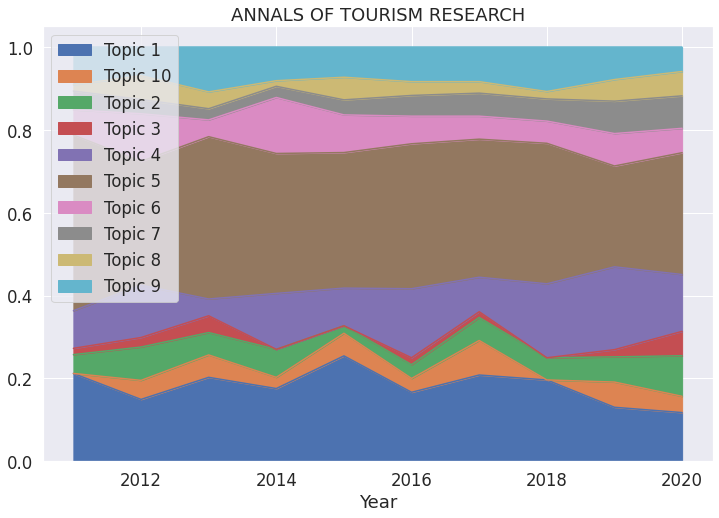

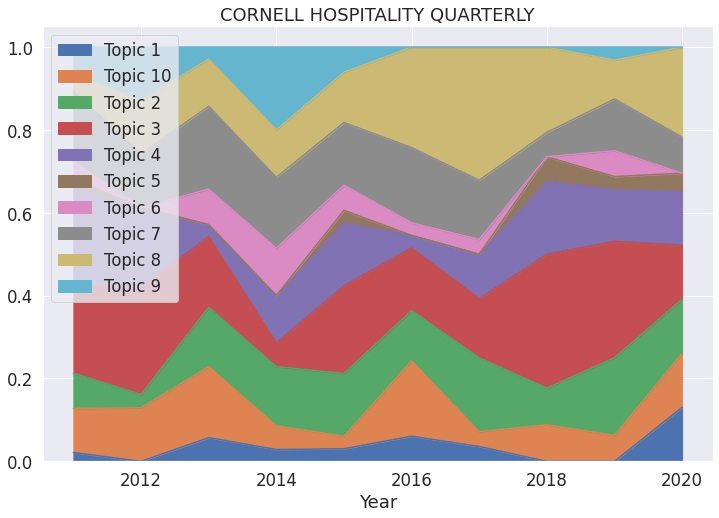

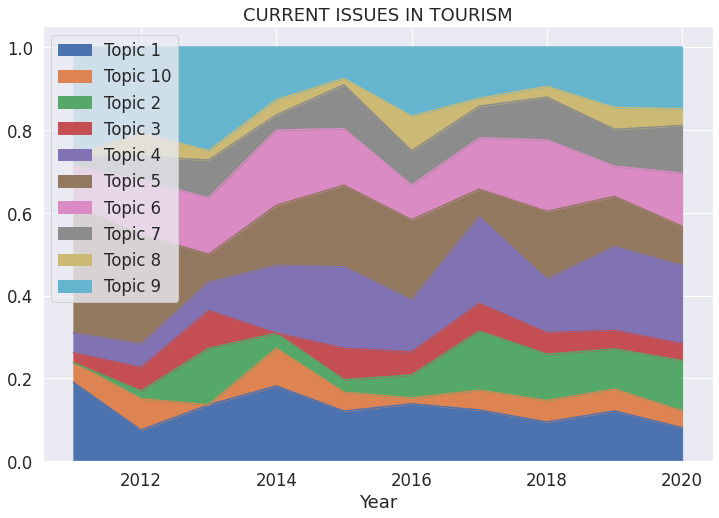

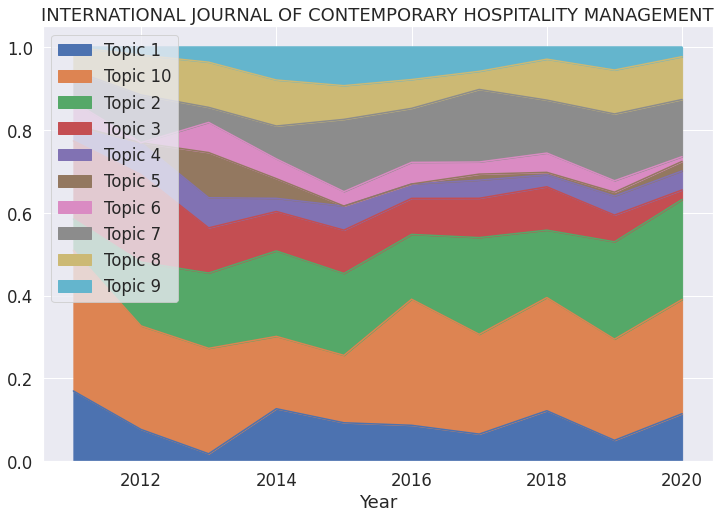

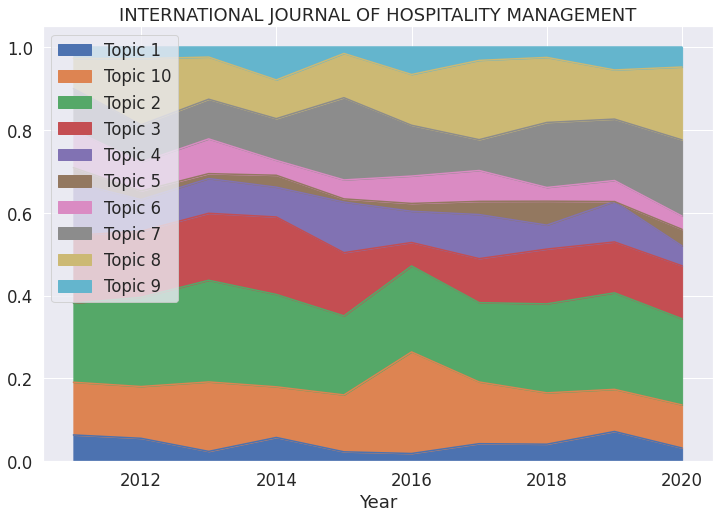

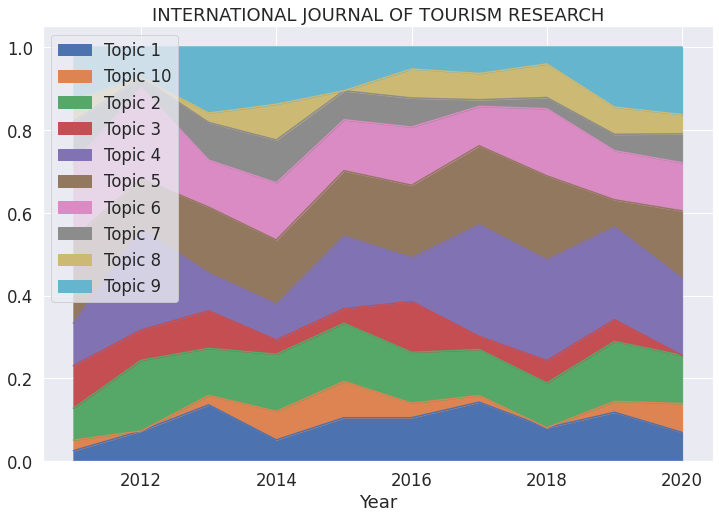

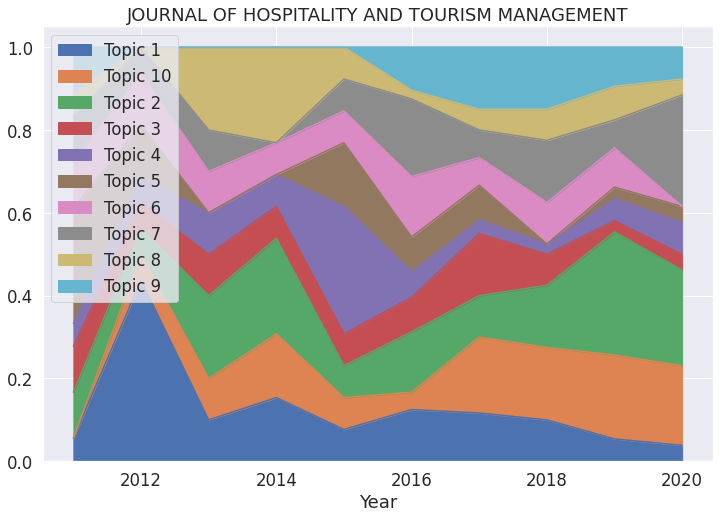

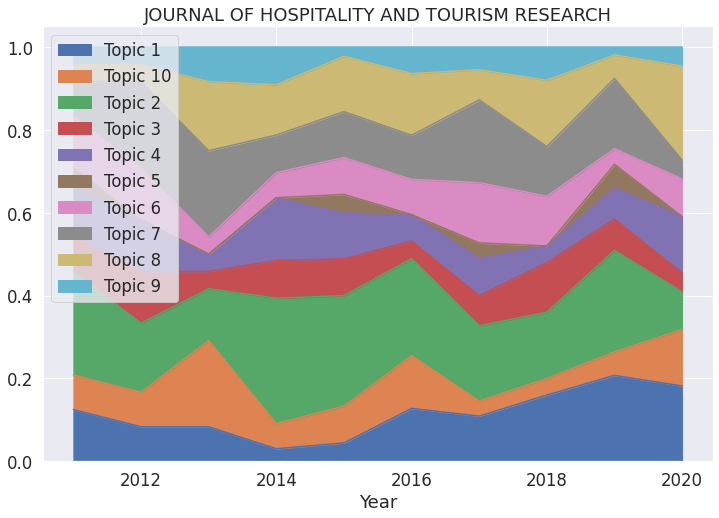

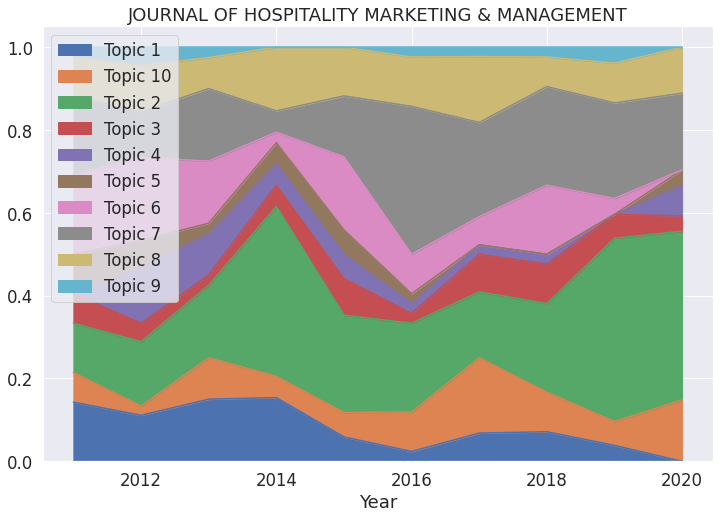

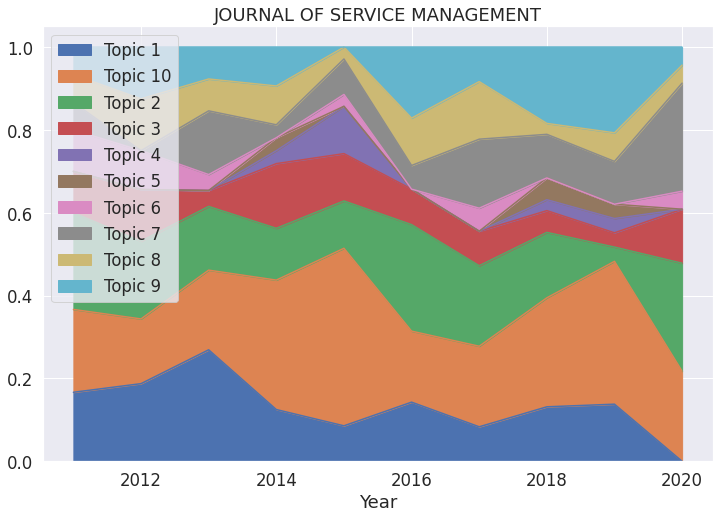

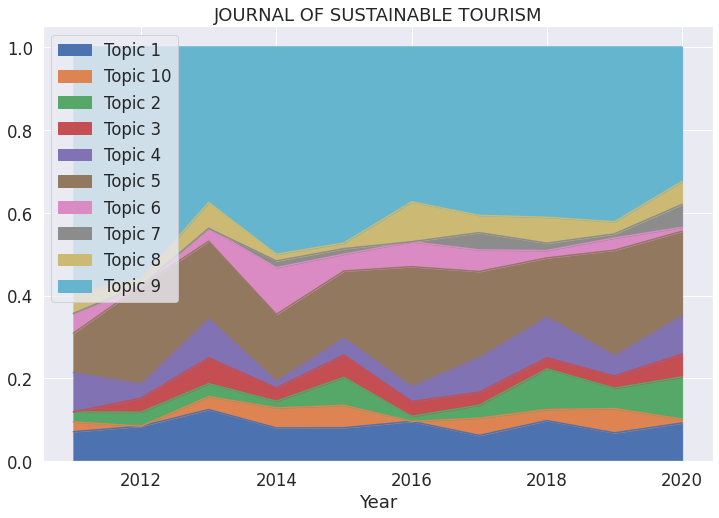

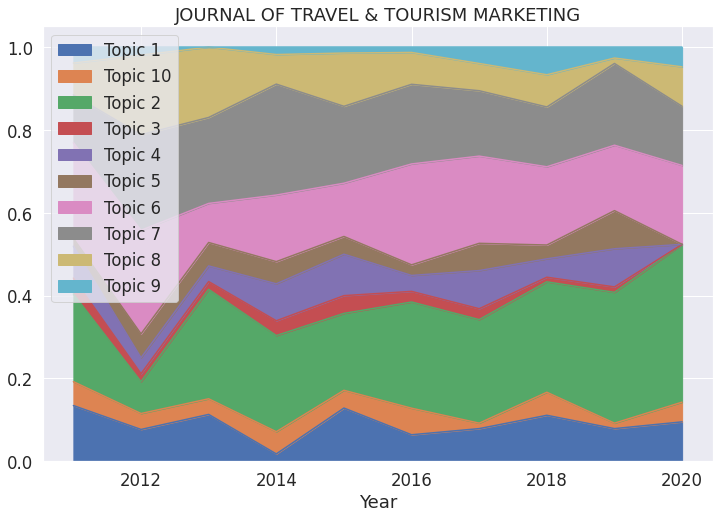

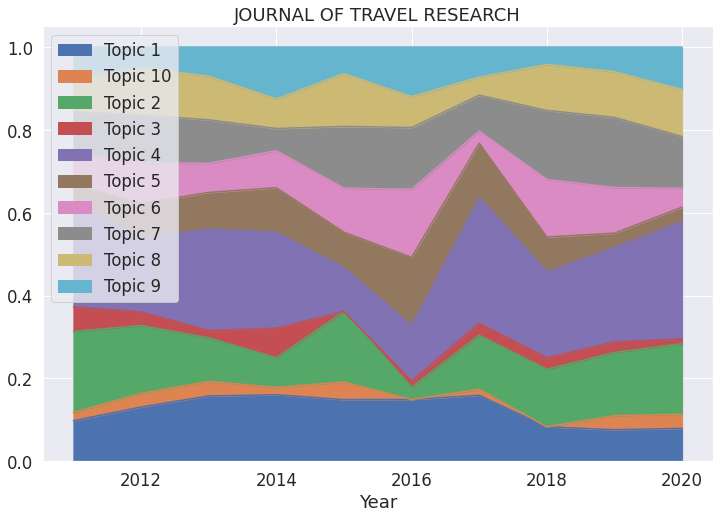

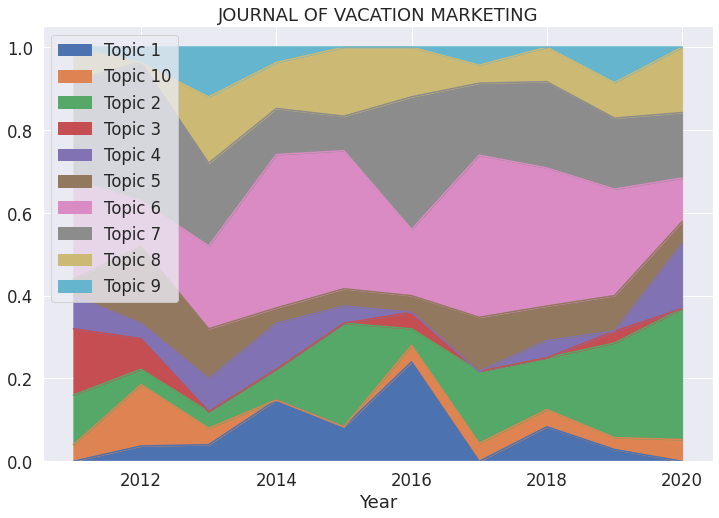

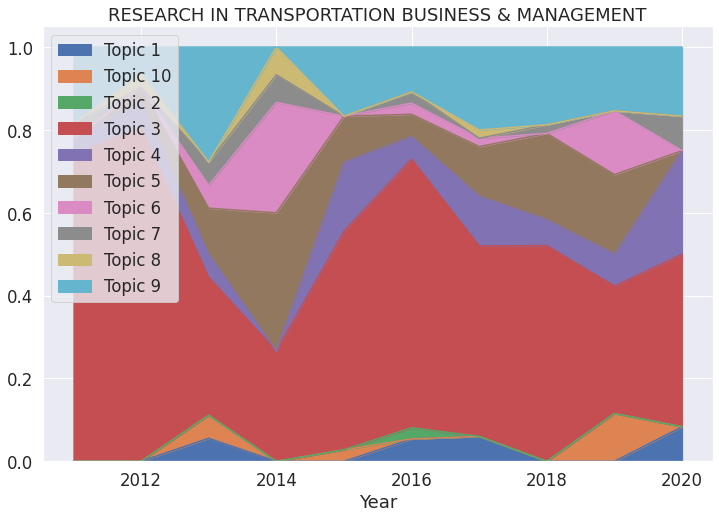

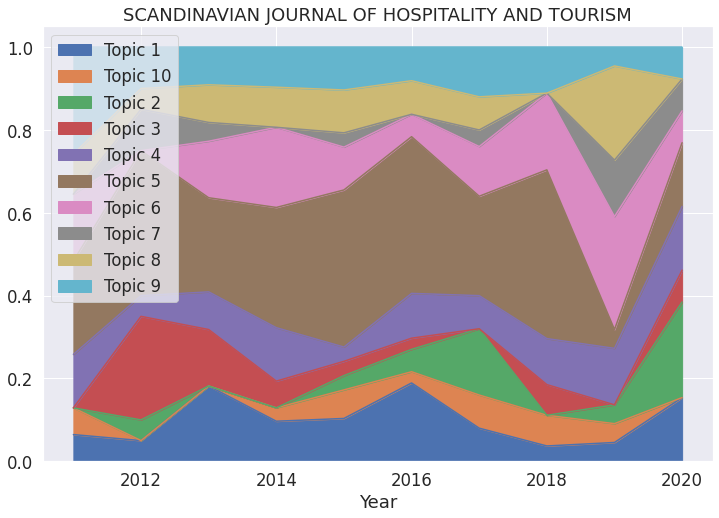

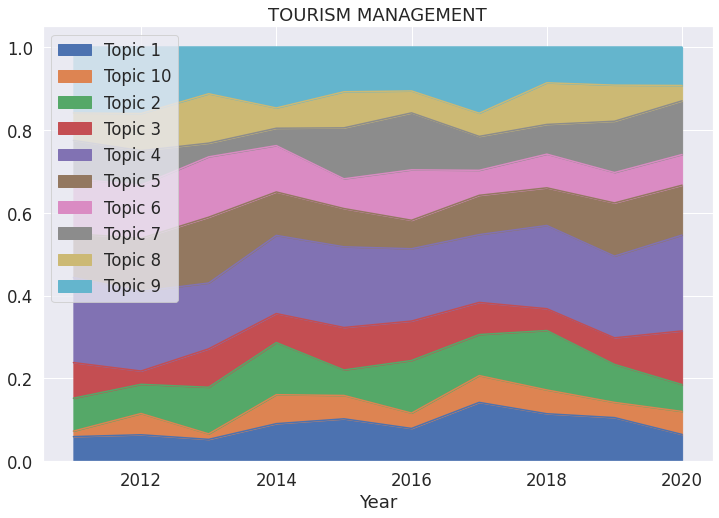

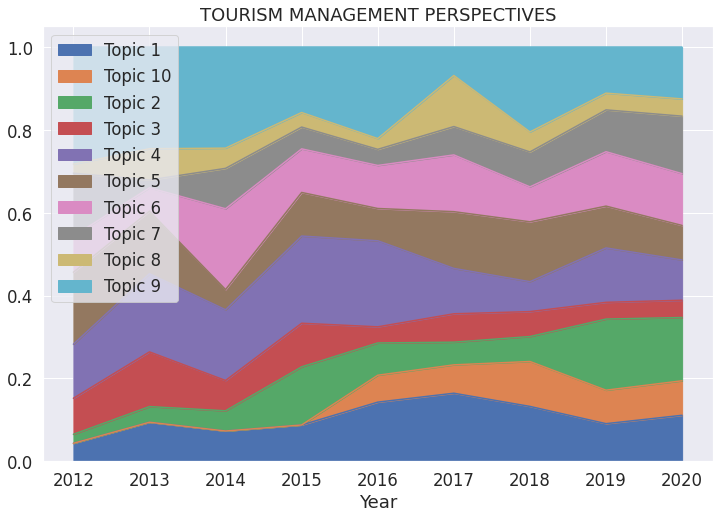

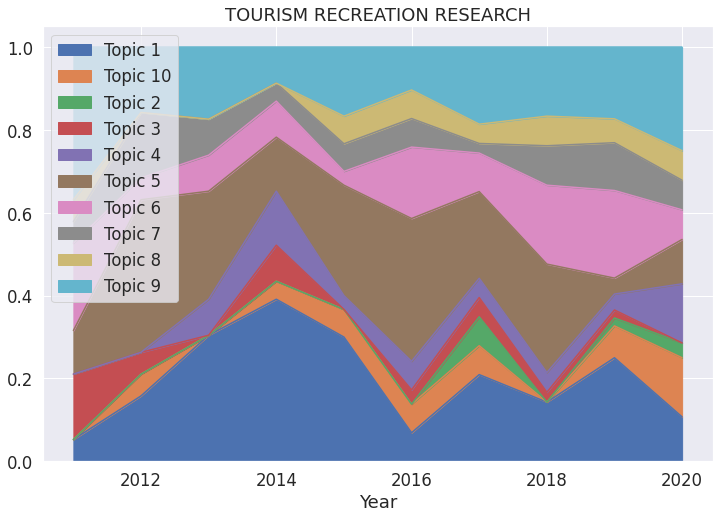

In [ ]:
for j in df_count_j.index.levels[0]:
  df_count_j.xs(j, level=0).plot.area()
  plt.title(j)
  plt.legend(loc='upper left')
  plt.show()


### LDA Tuning: Finding the Optimal Number of Topics

In [ ]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary, iterations=500, workers=cpus)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores

* We build several topic models, with the number of topics ranging from 2 to 50.

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus, texts=data_ready, dictionary=id2word,
                                                               start_topic_count=2, end_topic_count=50, step=1, cpus=16)

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 49/49 [46:57<00:00, 57.50s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 51, 1), 'Coherence Score': np.round(coherence_scores, 4)})

#coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

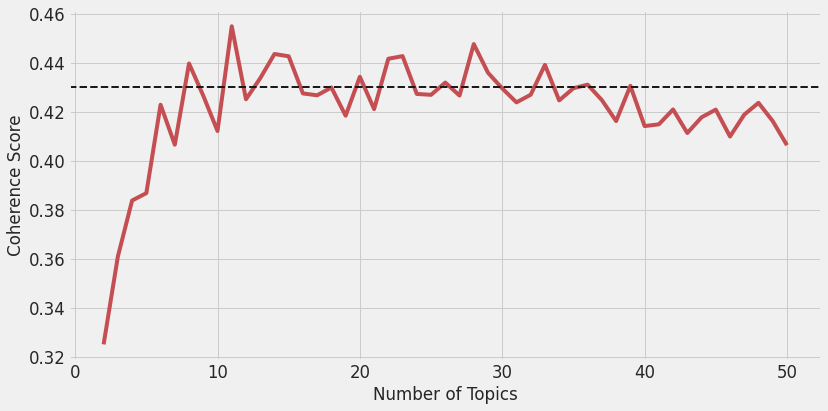

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


x_ax = range(2, 51, 1)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.43, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

* it looks like the score starts increasing rapidly until 10 topics and gradually starts plateauing.

In [ ]:
a10 = zip(range(2, 51, 1), coherence_scores)
a_10 = list(a10)
a_10

[(2, 0.3250433087279222),
 (3, 0.3608957964704595),
 (4, 0.3837822634877622),
 (5, 0.3868090548974414),
 (6, 0.4229080407617219),
 (7, 0.40656645192623014),
 (8, 0.4397408439494973),
 (9, 0.42659377887472866),
 (10, 0.41217194934435303),
 (11, 0.45492951646705576),
 (12, 0.4251310719221184),
 (13, 0.43372125452509197),
 (14, 0.44360851746944213),
 (15, 0.44268514063578535),
 (16, 0.4275130461543588),
 (17, 0.4267485391718844),
 (18, 0.42993462413112876),
 (19, 0.41841515513133143),
 (20, 0.43431789909408824),
 (21, 0.4211066281083574),
 (22, 0.44167388511627154),
 (23, 0.44274763079756335),
 (24, 0.42730656755184954),
 (25, 0.4269427557508108),
 (26, 0.43194379363877655),
 (27, 0.42664099248595383),
 (28, 0.4476581107687337),
 (29, 0.43596653749448405),
 (30, 0.42956422698269264),
 (31, 0.4238658826088721),
 (32, 0.42698750512098177),
 (33, 0.43917341932220805),
 (34, 0.42466670381812666),
 (35, 0.4296286483545955),
 (36, 0.4310934011631775),
 (37, 0.42478252356287355),
 (38, 0.4162278